Network data shape visualization
data	(10, 3, 224, 224)
conv1	(10, 96, 54, 54)
cccp1	(10, 96, 54, 54)
cccp2	(10, 96, 54, 54)
pool0	(10, 96, 27, 27)
conv2	(10, 256, 27, 27)
cccp3	(10, 256, 27, 27)
cccp4	(10, 256, 27, 27)
pool2	(10, 256, 13, 13)
conv3	(10, 384, 13, 13)
cccp5	(10, 384, 13, 13)
cccp6	(10, 384, 13, 13)
pool3	(10, 384, 6, 6)
conv4	(10, 1024, 6, 6)
cccp7	(10, 1024, 6, 6)
cccp8	(10, 1000, 6, 6)
pool4	(10, 1000, 1, 1)

Network parameters shape visualization
conv1	(96, 3, 11, 11) (96,)
cccp1	(96, 96, 1, 1) (96,)
cccp2	(96, 96, 1, 1) (96,)
conv2	(256, 96, 5, 5) (256,)
cccp3	(256, 256, 1, 1) (256,)
cccp4	(256, 256, 1, 1) (256,)
conv3	(384, 256, 3, 3) (384,)
cccp5	(384, 384, 1, 1) (384,)
cccp6	(384, 384, 1, 1) (384,)
conv4-1024	(1024, 384, 3, 3) (1024,)
cccp7-1024	(1024, 1024, 1, 1) (1024,)
cccp8-1024	(1000, 1024, 1, 1) (1000,)


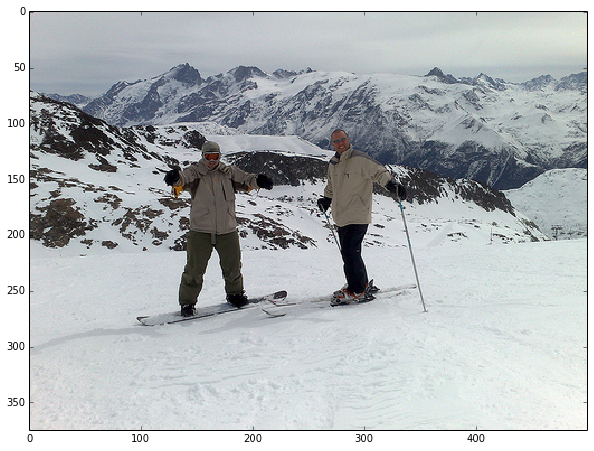

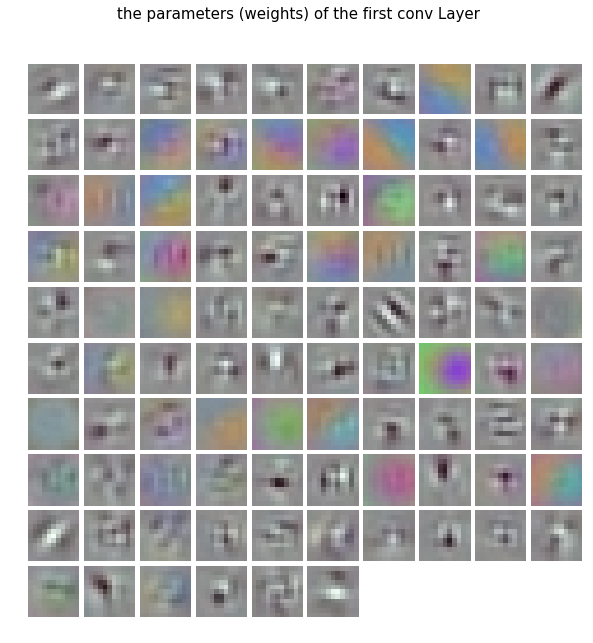

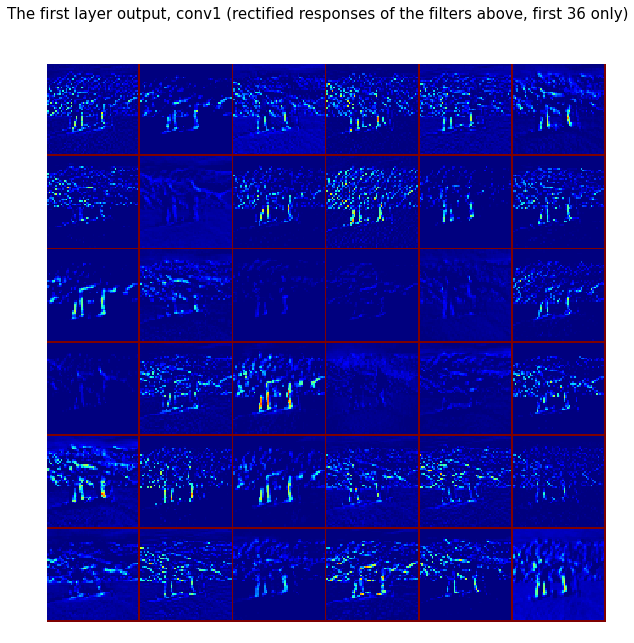

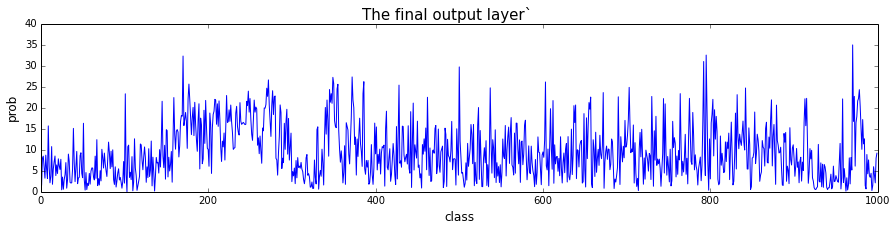

In [3]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'jet'  # use grayscale output rather than a (potentially misleading) color heatmap

## The caffe module needs to be on the Python path;
#  we'll add it here explicitly.

import sys
caffe_root = '../caffe'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe

caffe.set_mode_cpu()

model_def ='../models/NUS/deploy.prototxt'
model_weights ='../models/NUS/nin_imagenet_conv.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout


# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(10,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

image = caffe.io.load_image('../data/ILSVRC2012_img_val/ILSVRC2012_val_00000002.JPEG')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

print 'Network data shape visualization'
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
    
    
#Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.
# The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

print '\nNetwork parameters shape visualization'

for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
    
#Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

def vis_square(data,figureTitle):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    fig = plt.figure()
    fig.suptitle(figureTitle, fontsize=15)
    plt.imshow(data); plt.axis('off')
    
# First we'll look at the first layer filters, `conv1`

filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1),'the parameters (weights) of the first conv Layer')


feat = net.blobs['conv1'].data[0, :36]
vis_square(feat,'The first layer output, conv1 (rectified responses of the filters above, first 36 only)')

feat = net.blobs['pool4'].data[0]
fig = plt.figure(figsize=(15, 3))
fig.suptitle('The final output layer`', fontsize=15)
plt.xlabel('class', fontsize=12)
plt.ylabel('prob', fontsize=12)
plt.plot(feat.flat)